# TensorFlow Keras MNIST Classifier - Local Example

_**Train and export a TF.Keras CNN classifier for (a subset of) the [MNIST DIGITS](https://en.wikipedia.org/wiki/MNIST_database) dataset: Performing all storage and computation locally on the notebook.**_

This notebook works well with the `Python 3 (TensorFlow 1.15 Python 3.7 CPU Optimized)` kernel on SageMaker Studio, or `conda_tensorflow_p36` on classic SageMaker Notebook Instances.

---

The [dataset](https://s3.amazonaws.com/fast-ai-imageclas/mnist_png.tgz) is hosted in the Registry of Open Data on AWS and its extracted form is in "folders of PNGs" format more typical in image classification projects.

>❓*Can you figure out how to re-create this notebook's workflow using SageMaker more effectively?*

## Contents

1. **[Download and Reduce the Data](#Download-and-Reduce-the-Data)**
1. **[Load the Data From File](#Load-the-Data-From-File)**
1. **[Pre-Process the Data for our CNN](#Pre-Process-the-Data-for-our-CNN)**
1. **[Build a Model](#Build-a-Model)**
1. **[Fit the Model](#Fit-the-Model)**
1. **[Save the Trained Model](#Save-the-Trained-Model)**
1. [Explore Results](#Explore-Results)

See the accompanying **Instructions** notebook for more guidance!

In [1]:
# First install some libraries which might not be available across all kernels (e.g. in Studio):
!pip install ipywidgets matplotlib

You should consider upgrading via the '/usr/local/bin/python3.7 -m pip install --upgrade pip' command.


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os
import glob
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Conv2D, Dense, Dropout, Flatten, MaxPooling2D
from tensorflow.keras.models import Sequential

%matplotlib inline

print(f"Using TensorFlow version {tf.__version__}")
print(f"Keras version {tf.keras.__version__}")



Using TensorFlow version 1.15.5
Keras version 2.2.4-tf


## Download and Reduce the Data

Now let's download the image data. 
The original MNIST data has 70000 PNG files (60000 files in the training dataset, and 10000 in the test dataset). This takes a long time to train, so we want to reduce the amount of data before training for the purpose of this workshop.

In [3]:
# Download the MNIST data from the Registry of Open Data on AWS

target_path = "/tmp/mnist" #container storage
training_dir = f"{target_path}/training"
testing_dir = f"{target_path}/testing"


!rm -rf {target_path}
!mkdir -p {target_path}
!aws s3 cp s3://fast-ai-imageclas/mnist_png.tgz {target_path} --no-sign-request
    
# Un-tar the MNIST data, stripping the leading path element; this will lead us with directories {target_path}/testing/ and {target_path/training
!tar zxf {target_path}/mnist_png.tgz -C {target_path}/ --strip-components=1 --no-same-owner
!rm -f {target_path}/mnist_png.tgz
    

# get the list of files in tne training and testing directories recursively
train_files = sorted(list(glob.iglob(os.path.join(training_dir, "*/*.png"), recursive=True)))
test_files = sorted(list(glob.iglob(os.path.join(testing_dir, "*/*.png"), recursive=True)))

print(f"Training files: {len(train_files)}")
print(f"Testing files:  {len(test_files)}")

# get files from training and test folders by a defined reduction factor
reduction_factor = 2

train_files_to_keep = train_files[::reduction_factor]
test_files_to_keep = test_files[::reduction_factor]

print(f"Training files kept: {len(train_files_to_keep)}")
print(f"Testing files kept:  {len(test_files_to_keep)}")

# delete all the files not to be kept
train_delete = set(train_files) ^ set(train_files_to_keep)
test_delete = set(test_files) ^ set(test_files_to_keep)

for fname in train_delete:
    os.unlink(fname)

for fname in test_delete:
    os.unlink(fname)    

print("Done!")

download: s3://fast-ai-imageclas/mnist_png.tgz to ../../../tmp/mnist/mnist_png.tgz
Training files: 60000
Testing files:  10000
Training files kept: 30000
Testing files kept:  5000
Done!


## Load Reduced Data From Files

Now our images are stored in the `{target_path}` folder, let's read our training and testing sets in from these files.

```
    {target_path}
    |----------------.
    `-- testing      `-- training
        |-- 0       |-- 0 
        |               `-- 1.png
        |-- 1       |-- 1   
        |-- 2       |-- 2
        |-- 3       |-- 3
        |-- 4       |-- 4
        |-- 5       |-- 5
        |-- 6       |-- 6
        |-- 7       |-- 7
        |-- 8       |-- 8
        `-- 9       `-- 9
```

(For both training and testing) We'll loop through each folder taking the target label (`0`-`9`) from the folder name and loading each PNG into an image matrix.

In [4]:
from PIL import Image
labels = sorted(os.listdir(training_dir))
n_labels = len(labels)

x_train = []
y_train = []
x_test = []
y_test = []
print("Loading label ", end="")
for ix_label in range(n_labels):
    label_str = labels[ix_label]
    print(f"{label_str}...", end="")
    trainfiles = filter(
        lambda s: s.endswith(".png"),
        os.listdir(os.path.join(training_dir, label_str))
    )    
        
    for filename in trainfiles:
        # Can't just use tf.keras.preprocessing.image.load_img(), because it doesn't close its file
        # handles! So get "Too many open files" error... Grr
        with open(os.path.join(training_dir, label_str, filename), "rb") as imgfile:
            x_train.append(
                # Squeeze (drop) that extra channel dimension, to be consistent with prev format:
                np.squeeze(tf.keras.preprocessing.image.img_to_array(
                    Image.open(imgfile)
                ))
            )
            y_train.append(ix_label)

    # Repeat for test data:
    testfiles = filter(
        lambda s: s.endswith(".png"),
        os.listdir(os.path.join(testing_dir, label_str))
    )

    for filename in testfiles:
        with open(os.path.join(testing_dir, label_str, filename), "rb") as imgfile:
            x_test.append(
                np.squeeze(tf.keras.preprocessing.image.img_to_array(
                    Image.open(imgfile)
                ))
            )
            y_test.append(ix_label)
print()


print("Shuffling trainset...")
train_shuffled = [(x_train[ix], y_train[ix]) for ix in range(len(y_train))]
np.random.shuffle(train_shuffled)

x_train = np.array([datum[0] for datum in train_shuffled])
y_train = np.array([datum[1] for datum in train_shuffled])
train_shuffled = None

print("Shuffling testset...")
test_shuffled = [(x_test[ix], y_test[ix]) for ix in range(len(y_test))]
np.random.shuffle(test_shuffled)

x_test = np.array([datum[0] for datum in test_shuffled])
y_test = np.array([datum[1] for datum in test_shuffled])
test_shuffled = None

print("Done!")

Loading label 0...1...2...3...4...5...6...7...8...9...
Shuffling trainset...
Shuffling testset...
Done!


**Before we go ahead**, let's just quickly visualize the data distribution.

x_train.shape (30000, 28, 28); dtype float32
y_train.shape (30000,); dtype int64
x_test.shape (5000, 28, 28); dtype float32
y_test.shape (5000,); dtype int64


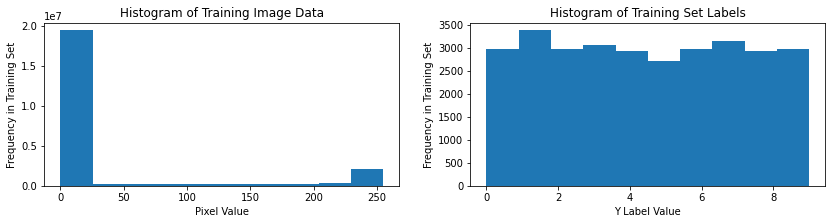

In [5]:
print(f"x_train.shape {x_train.shape}; dtype {x_train.dtype}")
print(f"y_train.shape {y_train.shape}; dtype {y_train.dtype}")
print(f"x_test.shape {x_test.shape}; dtype {x_test.dtype}")
print(f"y_test.shape {y_test.shape}; dtype {y_test.dtype}")

fig = plt.figure(figsize=(14, 3))
ax = plt.subplot(1, 2, 1)
#plt.hist(x_train_raw.flatten())
plt.hist(x_train.flatten())
ax.set_title("Histogram of Training Image Data")
ax.set_ylabel("Frequency in Training Set")
ax.set_xlabel("Pixel Value")

ax = plt.subplot(1, 2, 2)
plt.hist(y_train)
ax.set_title("Histogram of Training Set Labels")
ax.set_ylabel("Frequency in Training Set")
ax.set_xlabel("Y Label Value")

plt.show()

Some example images:


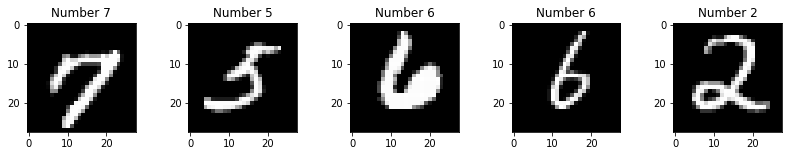

In [6]:
print("Some example images:")
fig = plt.figure(figsize=(14, 2))
for i in range(5):
    fig = plt.subplot(1, 5, i + 1)
    ax = plt.imshow(x_train[i], cmap="gray")
    fig.set_title(f"Number {y_train[i]}")
plt.show()

## Pre-Process the Data for our CNN

Next, we'll tweak this format for our neural network:

- Normalizing pixel values to improve the numerical conditioning
- One-hot encoding our labels to suit a softmax classifier output of probabilities for each digit
- Adding both a batch dimension (for processing multiple samples in parallel) and a channel dimension (e.g. as if this were a 3-channel RGB image, except single-channel for grayscale) - as well as the X and Y axes.

In [7]:
# Since we're actually feeding the images in to nets this time, we should actually pay attention
# to which way around Keras wants the channel dimension:
if K.image_data_format() == "channels_first":
    x_train = np.expand_dims(x_train, 1)
    x_test = np.expand_dims(x_train, 1)
else:
    x_train = np.expand_dims(x_train, len(x_train.shape))
    x_test = np.expand_dims(x_test, len(x_test.shape))

x_train = x_train.astype("float32")
x_test = x_test.astype("float32")
x_train /= 255
x_test /= 255

input_shape = x_train.shape[1:]

print("x_train shape:", x_train.shape)
print("input_shape:", input_shape)
print(x_train.shape[0], "train samples")
print(x_test.shape[0], "test samples")

# convert class vectors to binary class matrices
y_train = tf.keras.utils.to_categorical(y_train, n_labels)
y_test = tf.keras.utils.to_categorical(y_test, n_labels)

print("n_labels:", n_labels)
print("y_train shape:", y_train.shape)


x_train shape: (30000, 28, 28, 1)
input_shape: (28, 28, 1)
30000 train samples
5000 test samples
n_labels: 10
y_train shape: (30000, 10)


## Build a Model

At its core, the model is a 2D convolutional network with a softmax output layer that'll yield a confidence score for every possible label (e.g. 10 options for digit = 0 to 9).


In [8]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), activation="relu", input_shape=input_shape))
model.add(Conv2D(64, (3, 3), activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(n_labels, activation="softmax"))

model.compile(
    loss=tf.keras.losses.categorical_crossentropy,
    optimizer=tf.keras.optimizers.Adadelta(),
    metrics=["accuracy"]
)


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


## Fit the Model

Keras makes fitting and evaluating the model straightforward enough: We don't have any fancy hooks, and are happy with the default logging:


In [9]:
%%time
batch_size = 128
epochs = 12

model.fit(
    x_train, y_train,
    batch_size=batch_size,
    epochs=epochs,
    shuffle=True,
    verbose=1, # Hint: You might prefer =2 for running in SageMaker!
    validation_data=(x_test, y_test)
)

score = model.evaluate(x_test, y_test, verbose=0)
print(f"Test loss={score[0]}")
print(f"Test accuracy={score[1]}")


Train on 30000 samples, validate on 5000 samples
Epoch 1/12
30000/30000 [==============================] - 23s 765us/sample - loss: 2.3015 - acc: 0.1186 - val_loss: 2.2918 - val_acc: 0.2190
Epoch 2/12
30000/30000 [==============================] - 22s 745us/sample - loss: 2.2872 - acc: 0.1581 - val_loss: 2.2758 - val_acc: 0.2888
Epoch 3/12
30000/30000 [==============================] - 22s 729us/sample - loss: 2.2717 - acc: 0.2050 - val_loss: 2.2584 - val_acc: 0.3432
Epoch 4/12
30000/30000 [==============================] - 22s 726us/sample - loss: 2.2553 - acc: 0.2491 - val_loss: 2.2388 - val_acc: 0.3814
Epoch 5/12
30000/30000 [==============================] - 23s 782us/sample - loss: 2.2362 - acc: 0.2908 - val_loss: 2.2158 - val_acc: 0.4202
Epoch 6/12
30000/30000 [==============================] - 22s 737us/sample - loss: 2.2130 - acc: 0.3254 - val_loss: 2.1885 - val_acc: 0.4608
Epoch 7/12
30000/30000 [==============================] - 22s 729us/sample - loss: 2.1846 - acc: 0.3623 -

## Save the Trained Model

Keras has a built-in `model.save()` command, which in TensorFlow v2 can directly produce TensorFlow Serving-compatible outputs!

...However, this notebook runs TensorFlow v1. To save you the frustration of figuring it out (there's a nice blog post on the subject [here](https://aws.amazon.com/blogs/machine-learning/deploy-trained-keras-or-tensorflow-models-using-amazon-sagemaker/)), we'll give you a hint by saving the model here in TensorFlow Serving-ready format.


In [10]:
# The export folder needs to be empty, or non-existent
!rm -rf data/model/model/1

sess = K.get_session()
tf.saved_model.simple_save(
    sess,
    os.path.join("data/model", "model/1"),
    inputs={ "inputs": model.input },
    outputs={ t.name: t for t in model.outputs },
)

Instructions for updating:
This function will only be available through the v1 compatibility library as tf.compat.v1.saved_model.simple_save.


Instructions for updating:
This function will only be available through the v1 compatibility library as tf.compat.v1.saved_model.simple_save.


Instructions for updating:
This function will only be available through the v1 compatibility library as tf.compat.v1.saved_model.utils.build_tensor_info or tf.compat.v1.saved_model.build_tensor_info.


Instructions for updating:
This function will only be available through the v1 compatibility library as tf.compat.v1.saved_model.utils.build_tensor_info or tf.compat.v1.saved_model.build_tensor_info.


INFO:tensorflow:Assets added to graph.


INFO:tensorflow:Assets added to graph.


INFO:tensorflow:No assets to write.


INFO:tensorflow:No assets to write.


INFO:tensorflow:SavedModel written to: data/model/model/1/saved_model.pb


INFO:tensorflow:SavedModel written to: data/model/model/1/saved_model.pb


## Explore Results

Let's take a sample image from the test set, predict the label and plot it!


Result confidences: [[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


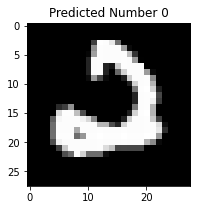

In [11]:
# Choose an image:
label = "2"
filename = os.listdir(f"{testing_dir}/{label}")[0]

# Load the image:
img = tf.keras.preprocessing.image.img_to_array(
    Image.open(f"{testing_dir}/{label}/{filename}")
)

# Expand out the "batch" dimension, and send to the model:
result = model.predict(np.expand_dims(img, 0))
print(f"Result confidences: {result}")

# Plot the result:
plt.figure(figsize=(3, 3))
fig = plt.subplot(1, 1, 1)
ax = plt.imshow(np.squeeze(img), cmap="gray")
fig.set_title(f"Predicted Number {np.argmax(result[0])}")
plt.show()

In [3]:
!git remote set-url origin git@github.com:rosalieandico/sagemaker-101-workshop.git

All done!
